In [1]:
#
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
#
import gsw
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)

In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
#
# parameters for the pre-processing step of CTD data sets
#

# data path
path_data = '../../data/'

# CTD (Ben) infos: path and filename
path_CTD_data = path_data + 'ITP_CTD_Ben/'
filename_CTD_data = path_CTD_data + 'mosaic.whoiitpmerged.newgrid.mat'
# selected ITP ('ITP92', 'ITP102', 'ITP111')
ITP_name = 'ITP111'

# Polarstern trajectory infos: path and filename
path_track = path_data + 'TRACK/' 
filename_track = path_track + 'Polarstern_daily_track.nc'

# mesh infos: path and filename
path_mesh = path_data + 'MESH/'
filename_mesh = path_mesh + 'REcoM1D_daily_mesh_v2.nc'

# parameter related to the processing steps
# infos about interpolation and extrapolation of profile data (1st step of processing)
temperature_extrapolation_high_depth_method = 'exponential' # linear or exponential convergence to freezing temperature
# width of the window in days for the moving average outlier removal (2nd step of processing)
window_width = 5
# Fill the gaps with CTD from Polarstern
fill_gaps_polarstern_CTD = True

# output infos: path and filename
path_output = path_data + 'ITP_CTD_Ben/'
filename_output = path_output + 'ITP_daily_data_v2.nc'
flag_smooth_output=True # flag whether to store smooth (moving averaged) salinity/temperature 2D fields or rough processed

In [3]:
#
# load ITP data: dates, coordinates, depth, temperature, salinity
#

# compute depth from pressure using gsw librairy
def compute_depth(pressure, latitude):
    depth = []
    for lat in latitude:
        tmp = gsw.z_from_p(pressure, lat)
        depth.append(gsw.z_from_p(pressure, lat))
    return np.asarray(depth)

# compute daily values of coordinates, temperature and salinity
def compute_daily_values(time, lon, lat, T, S):    
    # remove outliers
    ind=np.where(time>0)[0]
    time, lon, lat = time[ind], lon[ind], lat[ind]
    T, S = T[:,ind], S[:,ind]
    
    # sort dates (daily)
    dates, indices = np.unique(np.floor(time), return_inverse=True)
        
    # compute daily values
    longitude, latitude, temperature, salinity = [], [], [], []
    for i in range(len(dates)):
            index = np.where(indices==i)[0]
            #print (ind)
            # longitude, latitude, temperature, salinity
            tmp1, tmp2 = np.nanmean(lon[index]), np.nanmean(lat[index])
            tmp3, tmp4 = np.nanmean(T[:,index],-1), np.nanmean(S[:,index],-1)
            longitude.append(tmp1), latitude.append(tmp2), temperature.append(tmp3), salinity.append(tmp4)
            
    return dates, np.asarray(longitude), np.asarray(latitude), np.asarray(temperature), np.asarray(salinity)

# ITP data
class ITP_daily_data:
    def __init__(self,filename, ITP_name):
        self.estimate_daily_ITP_variables(filename, ITP_name)
        
    def estimate_daily_ITP_variables(self, filename, ITP_name):
        ## 1. load ITP data
        # define data index according to ITP_name
        if 'ITP92' in ITP_name:
            ind = 0
        elif 'ITP101' in ITP_name:
            ind = 1
        elif 'ITP111' in ITP_name:
            ind=-1
            
        # load data
        matdata = loadmat(filename)
        # dates (time axis)
        dates = matdata['julds'][:,ind]-366.
        
        # coordinates
        longitude, latitude = matdata['lons'][:,ind], matdata['lats'][:,ind]
        
        # salinity amd temperature
        salinity, temperature = matdata['salg'][:,:,ind],matdata['ptmpg'][:,:,ind]

        ## 2. compute daily values
        days, lon, lat, temp, sal = compute_daily_values(dates, longitude, latitude, temperature, salinity)
        
        ## 3. compute depth axis from pressure
        depth = compute_depth(matdata['pressg'][0], lat)
        
        ## 4. store data
        self.dates, self.longitude, self.latitude = days, lon, lat 
        self.depth, self.temperature, self.salinity = depth, temp, sal
#
# load data
#
ITP_data =  ITP_daily_data(filename_CTD_data, ITP_name)

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [4]:
#ITP_data.dates

In [5]:
#
# load Polarstern daily trajectory 
#
class Trajectory_Polarstern:
    def __init__(self, filename):
        self.read_trajectory(filename)

    def read_trajectory(self, filename):
        ncid = Dataset(filename, "r", format="NETCDF4")
        self.dates = ncid['dates'][:]
        self.longitude, self.latitude = ncid['longitude'][:], ncid['latitude'][:]
        ncid.close()
#
# load MOSAiC trajectory
#
trajectory = Trajectory_Polarstern(filename_track)

In [6]:
#
# load daily mesh data
#
class mesh_data:
    def __init__(self, filename):
        self.read_vertical_mesh(filename)
        
    def read_vertical_mesh(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        
        # read vertical mesh
        self.nlevels, self.Z = ncid.variables['nlevels'][:]-1, ncid.variables['Z'][:]
        ncid.close()
#
# read mesh information
#
mesh = mesh_data(filename_mesh)

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


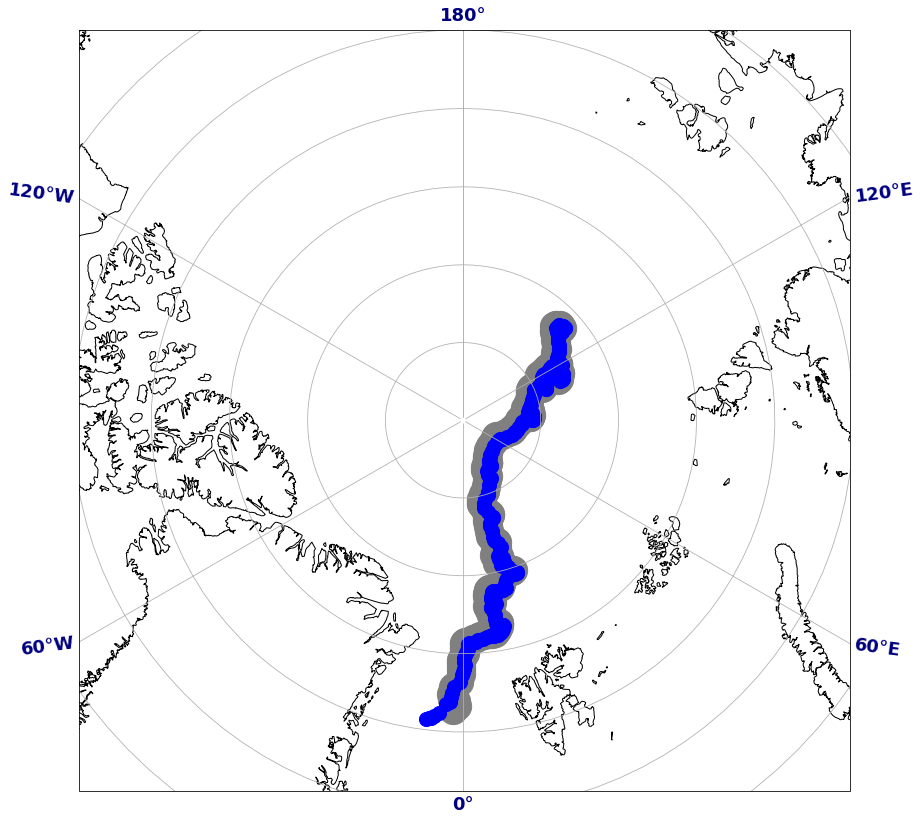

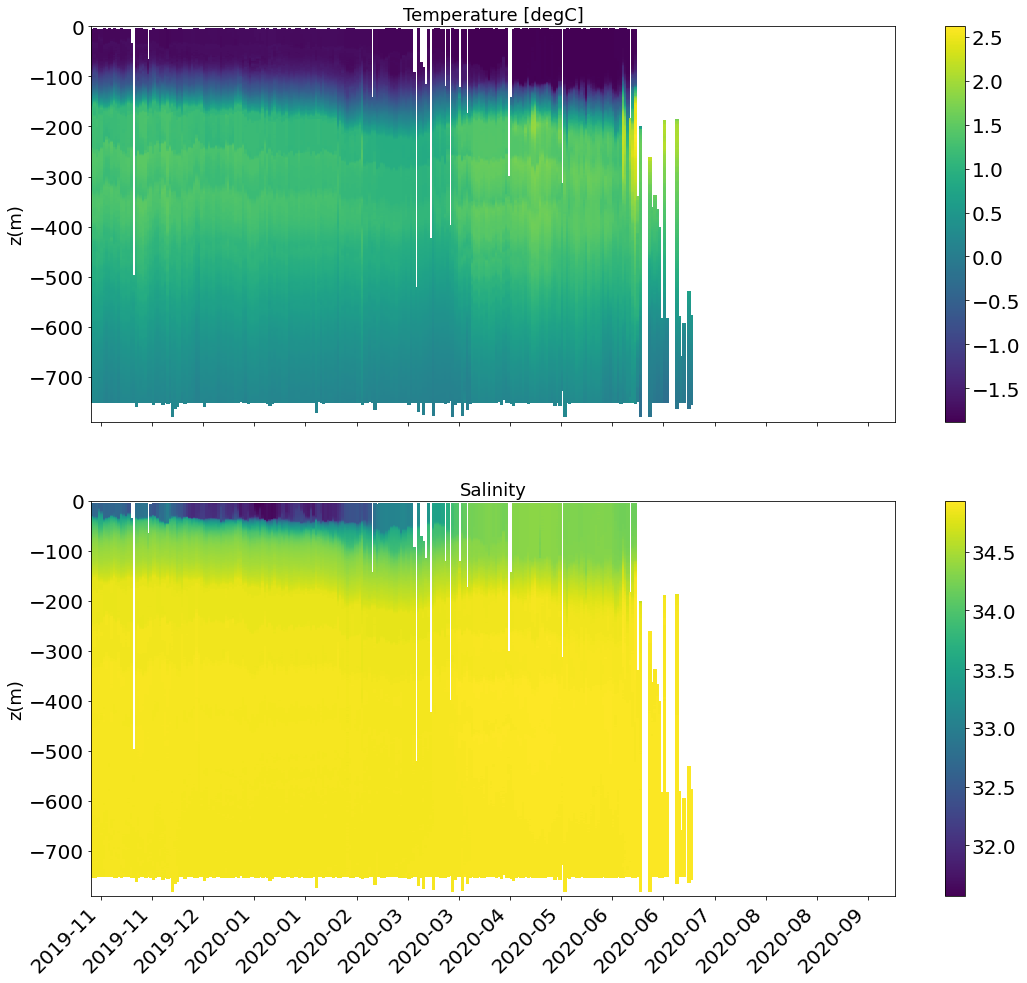

In [98]:
#
# Plot data for verification/visualization (track, 2D salinity/temperature)
#

# define Arctic map
def define_map():
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines(resolution='10m');
    #ax.stock_img()
    gl=ax.gridlines(draw_labels=True, dms=False)
    gl.xlabel_style = {'color': 'navy', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 0}
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    return(fig, ax)

# plot map
def plot_sensor_map(trajectory, data):
    Proj = ccrs.PlateCarree()
    fig, ax = define_map()
    plot_extent = [-180, 180, 75, 90]
    ax.set_extent(plot_extent, crs=Proj)
    lbsz, tcsz, mksz = 30, 20, 20
    rc('xtick', labelsize=tcsz) , rc('ytick', labelsize=tcsz)
    # trajectory of the Polarstern
    var=trajectory
    ax.scatter(var.longitude, var.latitude, c='0.5', s=800, transform=Proj)
    # trajectory of the sensor
    var=data
    ax.scatter(var.longitude, var.latitude, c='b', s=200, transform=Proj)
    
def plot_variables(data):
    date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
    tl = [np.min(mesh.dates)-date_ref, np.max(mesh.dates)-date_ref]
    fsz = (18,16)

    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)
    # temperature
    Dstr, D, nt, npd =np.zeros(data.temperature.shape).astype(str), np.zeros(data.temperature.shape), len(data.dates), data.temperature.shape[1]
    for i in range(npd):
        for j,dt in enumerate(data.dates):
            D[j,i]= dt
            Dstr[j,i] = datetime.strftime(datetime.fromordinal(int(dt)), '%Y-%m-%d')
    
    dates = D-date_ref
    
    im1 = ax[0].pcolor(dates, data.depth, data.temperature)
    ax[0].axvline(x=737587)
    ax[0].set_xlim(tl)
    ax[0].set_ylabel('z(m)', fontsize=18)
    ax[0].set_title('Temperature [degC]', fontsize=18)
    
    # salinity
    im2 = ax[1].pcolor(dates, data.depth, data.salinity)
    ax[1].set_xlim(tl)
    ax[1].set_ylabel('z(m)', fontsize=18)
    ax[1].set_title('Salinity', fontsize=18)
    
    ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 45)
    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    
    plt.colorbar(im1,ax=ax[0])
    plt.colorbar(im2,ax=ax[1])
    
    plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
    
    np.savez('CTD_ITP_raw.npz', dates = dates, depths = data.depth, 
         temperature = data.temperature, salinity = data.salinity, allow_pickle=True)
    
def plot_sensor_data(trajectory, data):
    # plot drift map
    plot_sensor_map(trajectory, data)
    
    # plot temperature and salinity
    plot_variables(data)
#
#
# plot sensor trajectory and salinity/temperature raw signal
plot_sensor_data(trajectory, ITP_data)

(330, 5000)
i =  0
(array([25]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  1
(array([26]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  2
(array([27]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  3
(array([28]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  4
(array([29]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  5
(array([30]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  6
(array([31]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  7
(array([32]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  8
(array([33]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  9
(array([34]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  10
(array([35]),)
(array([1]),)
Filling with ITP data
completing with Polarstern data
i =  11

i =  99
(array([124]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  100
(array([125]),)
(array([27]),)
Filling with ITP data
completing with Polarstern data
i =  101
(array([126]),)
(array([28]),)
Filling with ITP data
completing with Polarstern data
i =  102
(array([127]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  103
(array([128]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  104
(array([129]),)
(array([29]),)
Filling with ITP data
completing with Polarstern data
i =  105
(array([130]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  106
(array([131]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  107
(array([132]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  108
(array([133]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  109
(array([134]),)
(array([], dtype=int64),)
Filling with ITP data
NO

i =  202
(array([227]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  203
(array([228]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  204
(array([229]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  205
(array([230]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  206
(array([231]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  207
(array([232]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  208
(array([233]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  209
(array([234]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  210
(array([235]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  211
(array([236]),)
(array([], dtype=int64),)
Filling with ITP data
NO Polarstern data
i =  212
(array([237]),)
(array([], dtype=int64),)
Filling with ITP data
NO Pola

i =  293
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  294
(array([], dtype=int64),)
(array([68]),)
no ITP data
Polarstern data only
i =  295
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  296
(array([], dtype=int64),)
(array([69]),)
no ITP data
Polarstern data only
i =  297
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  298
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  299
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  300
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  301
(array([], dtype=int64),)
(array([], dtype=int64),)
no ITP data
no Polarstern data either, filling with NaN
i =  302
(array

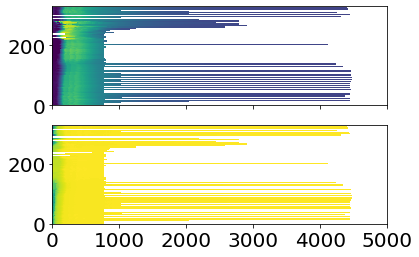

In [12]:
#
# Fill the gaps with CTD polarstern
#

date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
t1 = [np.min(mesh.dates)-date_ref, np.max(mesh.dates)-date_ref]

if (fill_gaps_polarstern_CTD):
    polarstern_ctd = np.load('../CTD_Polarstern/CTD_Polarstern_raw.npz')
    itp_ctd = np.load('CTD_ITP_raw.npz')
    
# date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
# t1 = [np.min(mesh.dates)-date_ref, np.max(mesh.dates)-date_ref]
# print(t1)
# #for d in np.arange(t1[0],t1[1]):

temp_composite = np.nan * np.zeros((len(np.arange(t1[0],t1[1])), polarstern_ctd['temperature'].shape[1]))
salt_composite = np.nan * np.zeros((len(np.arange(t1[0],t1[1])), polarstern_ctd['salinity'].shape[1]))
print(np.shape(temp_composite))

for i, d in enumerate(np.arange(t1[0],t1[1])):
    ind_time_itp = np.where(itp_ctd['dates'][:,0] == d)
    ind_time_polarstern = np.where(polarstern_ctd['dates'][:,0] == d)
    
    print('i = ', i)
    print(ind_time_itp)
    print(ind_time_polarstern)
    if np.any(ind_time_itp) == False:
        print('no ITP data')
        if np.any(ind_time_polarstern) == False:
            print('no Polarstern data either, filling with NaN')
        elif np.any(ind_time_polarstern) == True:
            print('Polarstern data only')
            temp_composite[i,1:] = polarstern_ctd['temperature'][ind_time_polarstern[0],:-1]
            salt_composite[i,1:] = polarstern_ctd['salinity'][ind_time_polarstern[0],:-1]
    else:
        print('Filling with ITP data')
        temp_composite[i,:801] = itp_ctd['temperature'][ind_time_itp[0],:]
        salt_composite[i,:801] = itp_ctd['salinity'][ind_time_itp[0],:]
        if np.any(ind_time_polarstern) == True:
            print('completing with Polarstern data')
            ind1 = np.isnan((temp_composite[i,1:]))
            ind2 = np.isnan((polarstern_ctd['temperature'][ind_time_polarstern[0],:-1]))
            ind_depths = np.where((ind1 == True) & (ind2 == False))[1]
            temp_composite[i,ind_depths+1] = polarstern_ctd['temperature'][ind_time_polarstern[0],ind_depths]
            salt_composite[i,ind_depths+1] = polarstern_ctd['salinity'][ind_time_polarstern[0],ind_depths]
        elif np.any(ind_time_polarstern) == False:
            print('NO Polarstern data')

# plt.plot(itp_ctd['dates'][:,0])
# plt.plot(polarstern_ctd['dates'][:,0])

class Object(object):
    pass


COMPOSITE_CTD = Object()
COMPOSITE_CTD.dates = np.arange(t1[0],t1[1]) + date_ref
#COMPOSITE_CTD.dates = np.tile(np.arange(t1[0],t1[1]) + date_ref, (5000, 1)).T
COMPOSITE_CTD.depth = - np.tile(np.arange(0,5000), (330, 1))
COMPOSITE_CTD.temperature = temp_composite
COMPOSITE_CTD.salinity = salt_composite

fig,ax = plt.subplots(2, sharex=True)
ax[0].pcolor(temp_composite)
ax[1].pcolor(salt_composite)

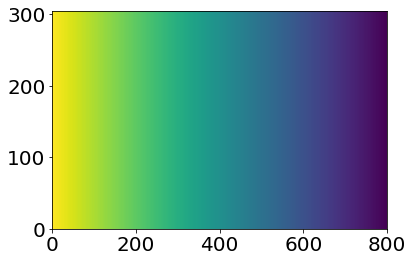

In [13]:
plt.pcolor(ITP_data.depth)

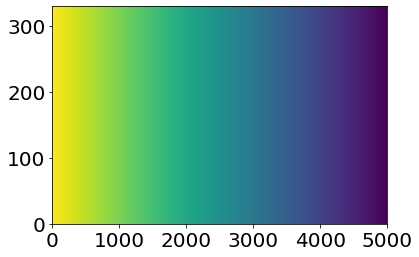

In [14]:
plt.pcolor(COMPOSITE_CTD.depth)

In [69]:
np.shape(COMPOSITE_CTD.depth)

(330, 5000)

tmin =  0.9082364571495526
tmin =  0.9465117670567749
tmin =  0.930133025870588
tmin =  0.9220589187459785
tmin =  0.861594455263814
tmin =  0.8350280129466416
tmin =  0.8179767081701411
tmin =  0.8522160102463574
tmin =  0.8569013026159636
tmin =  0.8656082359492151
tmin =  0.8420239378870567
tmin =  0.9447659935490829
tmin =  0.9392154058374549
tmin =  0.9154640962606214
tmin =  0.9241738267589614
tmin =  0.9238097702303273
tmin =  0.899
tmin =  0.9426146986298773
tmin =  1.0267884972932126
tmin =  1.0731691326209214
tmin =  1.09608419790831
tmin =  1.0192115790671683
tmin =  0.9715368955681765
tmin =  0.9080396447424053
tmin =  0.906915251988206
tmin =  0.8417402514124739
tmin =  0.8334937961032438
tmin =  0.8786106834270704
tmin =  0.9278987549488669
tmin =  0.917368924389436
tmin =  1.0050773905425558
tmin =  0.9165361753651147
tmin =  0.9216452712555947
tmin =  0.9145512957638067
tmin =  0.9418635123739834
tmin =  0.9805053487252102
tmin =  0.87714991653905
tmin =  0.929510826569

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


tmin =  0.7692177566476264
tmin =  0.73572372844579
tmin =  0.9034680252495211
tmin =  0.867449804734288
tmin =  0.8536095329347025
tmin =  0.8922142787594671
tmin =  0.8777644888566909
tmin =  0.9156627246188306
tmin =  0.8453356411368983
tmin =  0.8354231067196926
tmin =  0.8530013204016714
tmin =  0.8892103759159546
tmin =  0.8638321734703601
tmin =  0.9020068579323122
tmin =  0.8722207318057491
tmin =  0.8959056874457847
tmin =  0.92906810749469
tmin =  0.9335025913780308
tmin =  0.9455367060754274
tmin =  0.8801131517400596
tmin =  0.8688894465628556
tmin =  0.9377203547911371
tmin =  0.957743280244471
tmin =  0.961226520859783
tmin =  0.9502512686431652
tmin =  0.9428636616030369
tmin =  0.9035597631179504
tmin =  0.9010772353301207
tmin =  0.8883226802910651
tmin =  0.9226248875687372
tmin =  0.8507118567457985
tmin =  0.8623013123824906
tmin =  0.8983903362796261
tmin =  0.8585939929151456
tmin =  0.8847473841897636
tmin =  0.903592753464695
tmin =  0.8990031061917546
tmin =  0

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply


tmin =  0.8668504928675134
tmin =  0.8573883202396066
tmin =  0.8815859542127245
tmin =  0.859656031227219
tmin =  0.9303928724263486
tmin =  0.8728718887209359
tmin =  0.8714178533079066
tmin =  0.8498854890514673
tmin =  0.8357084255405072
tmin =  0.8525892809524827
tmin =  0.8638328763102655
tmin =  0.8560911235257804
tmin =  0.8240845102378234
tmin =  0.7390254229937343
tmin =  0.8926016885863108
tmin =  0.8571200946608345
tmin =  0.810010792242936
tmin =  0.8323474384752382
tmin =  0.8626380586164882
tmin =  0.8431162226791051
tmin =  0.8468610760083208
tmin =  0.8636343879415864
tmin =  0.8888490342674413
tmin =  0.9761451116444666
tmin =  0.8082967287225256
tmin =  0.8136208193292912
tmin =  0.7940094933300328
tmin =  0.8194727553626012
tmin =  0.8120037943057846
tmin =  0.8298625724043655
tmin =  0.827781612097802
tmin =  0.7821356493560183
tmin =  0.7896673796180727
tmin =  0.7934640209379089
tmin =  0.8070733317222749
tmin =  0.812486199230853
tmin =  0.8017299918059024
tmin 

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor relea

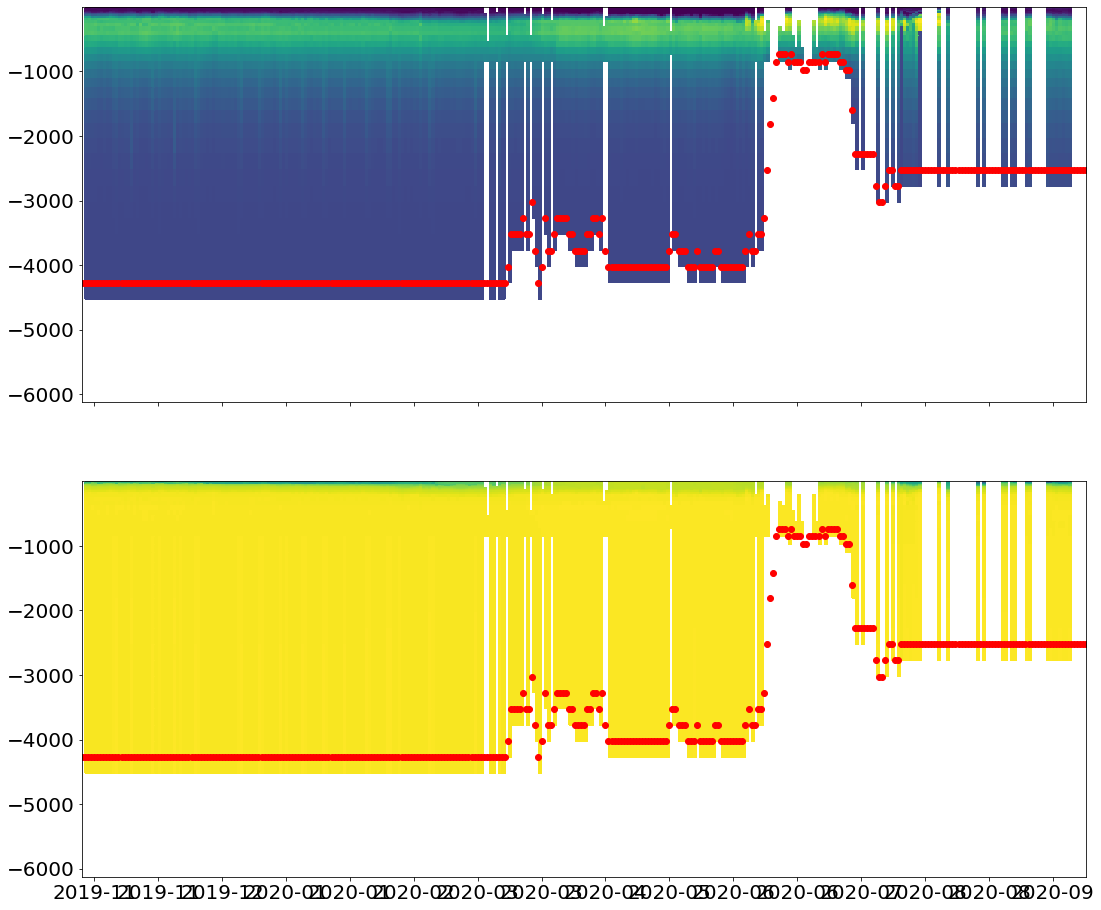

In [110]:
#
# 1st processing step:
# functions to extrapolate ITP salinity and temperature profiles to the surface and high depth 
#

# 1. salinity
# extend salinity profile to the surface (constant near the surface)
def extrapolate_salinity_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    #extend linearly to the surface
    outp[ind] = 2*outp[ind+1] - outp[ind+2]
    return outp

# extend salinity to high depth (constant deeper)   
def extrapolate_salinity_high_depth(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp))[0]
    if np.any(ind) == True:
        sp = outp[ind[0]-1]
        outp[ind] = sp
    
    return outp

# 2. temperature
# extend temperature profile linearly to the surface
def extrapolate_temperature_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    if len(ind)<2:
                #extend linearly to the surface
                outp[ind] = outp[ind+1]
    return outp

# extend temperature profile to high depth either linearly or with an exponential convergence to the freezing temperature
def extrapolate_temperature_high_depth(inp,method, depth=[], D=[], T=[], tmin=[], Tf=[], zref=-500):
    outp = np.copy(inp)
    thr=1e-5
    ind = np.where(np.isnan(inp[:]))[0]
    np.any(ind)
    if np.any(ind) == True:
        if method=='linear':
            for i in ind:
                outp[i] = 2*outp[i-1] - outp[i-2]

        elif method=='exponential':

            # computation indices indices 
            # data
            
            ind, indnan = np.where(D<zref)[0], np.where(~np.isnan(T))[0]
            indices = list(set(ind) & set(indnan)) 
            
            if any(indices) == False:
                zref = np.nanmin(D[indnan-1])
                
            ind, indnan = np.where(D<zref)[0], np.where(~np.isnan(T))[0]
            indices = list(set(ind) & set(indnan)) 
                
            x1, y1 = abs(D[indices]), T[indices]
            # gridded
            index = np.where(depth<=zref)[0]
            x2 = abs(depth[index]) 
            # exponential decay to be fitted
            def func(x,a):
                y = tmin - (tmin-Tf) *(1- np.exp(-a*(x-x1[0])))
                #y = Tf - (Tf-tmin) *(1- np.exp(-a*(x-x1[0])))
                return y

            # fit function to data
            popt, pcov = curve_fit(func, x1, y1)
            y2 = func(x2,*popt)
            #store data
            outp[index] = y2
        
    return outp

# compute freezing temperature according to salinity profiles
def compute_freezing_temperature(salinity):
    a = -18.48
    b = -a/1000.
    
    Tf = salinity/(a + b * salinity)
    
    return Tf

# plot_map
def plot_variables_map(var, mesh):
    fsz = (18,16)
    dl = [-5000, 0]
    date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)

    # temperature
    ax[0].pcolor(var.dates-date_ref, var.depth, var.temperature.T)
    for i, nlvl in enumerate(mesh.nlevels.astype(int)):
        ax[0].plot_date(mesh.dates[i]-date_ref, mesh.Z[nlvl],'or')
    #ax[0].pcolor(var.temperature)
    #ax[0].set_ylim(dl), ax[0].set_ylabel('z(m)', fontsize=18)
    
    # salinity
    ax[1].pcolor(var.dates-date_ref, var.depth, var.salinity.T)
    for i, nlvl in enumerate(mesh.nlevels.astype(int)):
        ax[1].plot_date(mesh.dates[i]-date_ref, mesh.Z[nlvl],'or')
    #ax[1].pcolor(var.salinity.T)
    #ax[1].set_xlim(tl)
    
    #ax[1].set_ylim(dl), ax[1].set_ylabel('z(m)', fontsize=18)
    
    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
# 
# perform vertical interpolation and extrapolation
#
class vertical_interpolation:
    def __init__(self, data, mesh):
        self.perform_vertical_interpolation(data, mesh)
        
    def perform_vertical_interpolation(self,data, mesh):
        # initialization
        self.dates, self.depth = mesh.dates, mesh.Z
        nt, nz = len(mesh.dates), len(mesh.Z)
        temperature, salinity = np.zeros((nt,nz))*np.nan, np.zeros((nt,nz))*np.nan
        indsal, indtemp = [], []
        # vertical interpolation according to bathymetry
        dat = mesh.dates
        
        date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
        
        # process the different ITP profiles separately
        for i, dt in enumerate(dat):
            # A. initialization
            # vertical level
            nl = int(mesh.nlevels[i])
            Z = [z for z in mesh.Z[:nl+1]]
            
            # find corresponding time in data
            indt = np.where(abs(data.dates-dt)<1e-3)[0]
            #print('i = ',i,', dt = ',dt,', indt = ', indt)
            
            if np.any(indt) == True:
                datad, datas, datat = data.depth[indt][0], data.salinity[indt][0], data.temperature[indt][0]
                # print(np.shape(datad), np.shape(datas), np.shape(datat))
                # B. perform rough interpolation of the salinity/temperature profile
                # perform interpolation
                # salinity
                f=interp1d(datad, datas, fill_value='extrapolate')
                sal = f(Z)
                # temperature
                f=interp1d(datad,datat, fill_value='extrapolate')
                temp=f(Z)

                # C. extend salinity profile to the surface and in high depth
                # process gap in salinity
                # idea: - interpolate on the 1st meters
                #       - extend linearly (same value) in high depth
                #       - test if data are sufficient in the profile 
                #         otherwise leave NaN that will be interpolated temporally
                # extend linearly to the surface
                ind = np.where(np.isnan(sal[:10]))[0]

                if len(ind)<2:
                    #extend linearly to the surface
                    sal = extrapolate_salinity_surface(sal)

                    # extend linearly to high depth
                    sal = extrapolate_salinity_high_depth(sal)

                else:
                    indsal.append(i)



                # D. extend temperature profile to the surface and in high depth
                # process gap in temperature
                # idea : - extend linearly in the first meters
                #        - extend in high depth either linearly or with an exponential convergence to freezing temperature or reference temperature
                #
                # estimate freezing temperature from salinity
                # Tf = compute_freezing_temperature(sal[-1])
                # Here we chose the bottom potential temperature from Polarstern CTD (more realistic)
                Tf = -0.928
                ind = np.where(np.isnan(temp[:10]))[0]

                if len(ind)<2:
                    dref = - 500
                    #extend linearly to the surface
                    temp = extrapolate_temperature_surface(temp)
                    # extend linearly to high depth
                    #temp = extrapolate_temperature_high_depth(temp,'linear')
                    
                    
                    tmin = datat[np.where(datad<=dref)[0][0]]
                    print('tmin = ',tmin)
                    if np.isnan(tmin) == True:
                        tmin = temp[(~np.isnan(temp)).sum(axis = 0) - 1]
                        print('tmin 2 = ',tmin,', dt = ', dt)
                    temp = extrapolate_temperature_high_depth(temp, temperature_extrapolation_high_depth_method, self.depth[:nl+1], datad, datat, tmin, Tf, dref)

                else:
                    indtemp.append(i)

                # store data
                salinity[i,:nl+1], temperature[i,:nl+1] = sal, temp
            
        self.salinity, self.temperature = salinity, temperature
        self.indtemp, self.indsal = indtemp, indsal
#
# extend ITP salinity/temperature profiles to the surface and high depth
#
# if fill_gaps_polarstern_CTD:
#     ITP_data_processed_1st_step = vertical_interpolation(COMPOSITE_CTD,mesh)
# else:
ITP_data_processed_1st_step = vertical_interpolation(COMPOSITE_CTD,mesh)

#
# plot 2D salinity/temperature field that are resulting from this extrapolation processing
#
plot_variables_map(ITP_data_processed_1st_step, mesh)

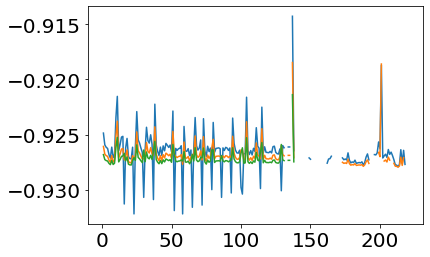

In [103]:
np.shape(ITP_data_processed_1st_step.temperature)

plt.plot(ITP_data_processed_1st_step.temperature[:,-10:])

/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


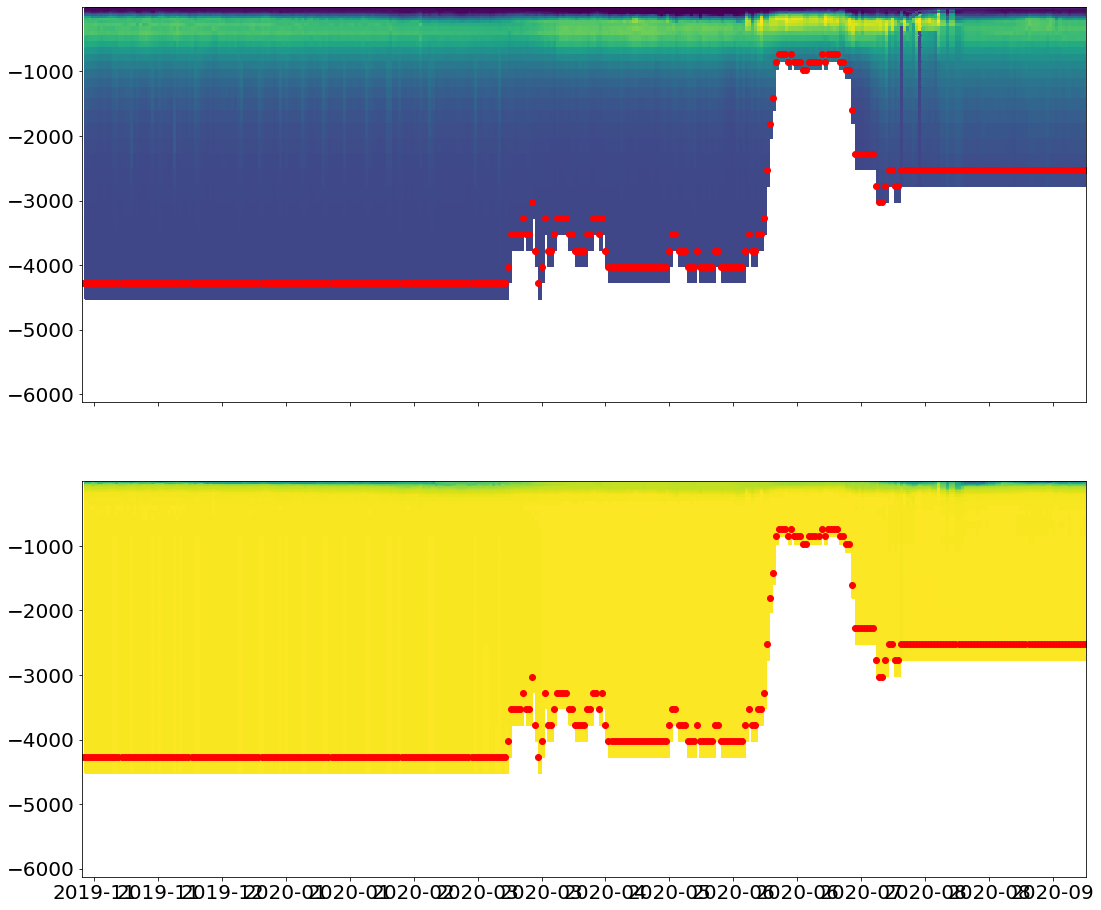

In [104]:
#
# 2nd processing step:
# perform a temporal moving average in the vicinity of the outlier profile to estimate a mean profile at this location

def outlier_moving_average(dates, var, mesh, indices, width):
    
    # initialization
    output = np.copy(var)
    nt = len(dates)
    
    for i in indices:
        # compute moving average in temporal window
        ind1, ind2 = np.max([0, i-width]), np.min([i+width,nt-1])
        jind = np.linspace(ind1,ind2, ind2-ind1+1).astype(int)
        mvar = np.nanmean(var[jind,:],0)
        # compute outlier profile as the mean of the window
        output[i,:] = mvar
        # mask on bottom mesh levels (not accounted for in the computation)
        nlvl = int(mesh.nlevels[i])
        output[i,nlvl+1:] = np.nan
    return output


# process salinity  and temperature outliers
# idea : temporal moving average on a given window
class temporal_moving_average:
    def __init__(self, data, mesh, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, mesh.nlevels
        
        self.salinity, self.temperature = np.copy(data.salinity), np.copy(data.temperature)
        
        self.perform_temporal_moving_average(data, mesh, width)
        
    def perform_temporal_moving_average(self, var, mesh, width):
        
        # salinity
        self.salinity = outlier_moving_average(var.dates, var.salinity, mesh, var.indsal, width)
        
        # temperature
        self.temperature = outlier_moving_average(var.dates, var.temperature, mesh, var.indtemp, width)
        
#
ITP_data_processed_2nd_step = temporal_moving_average(ITP_data_processed_1st_step, mesh, window_width)
plot_variables_map(ITP_data_processed_2nd_step,mesh)

(331, 47)


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


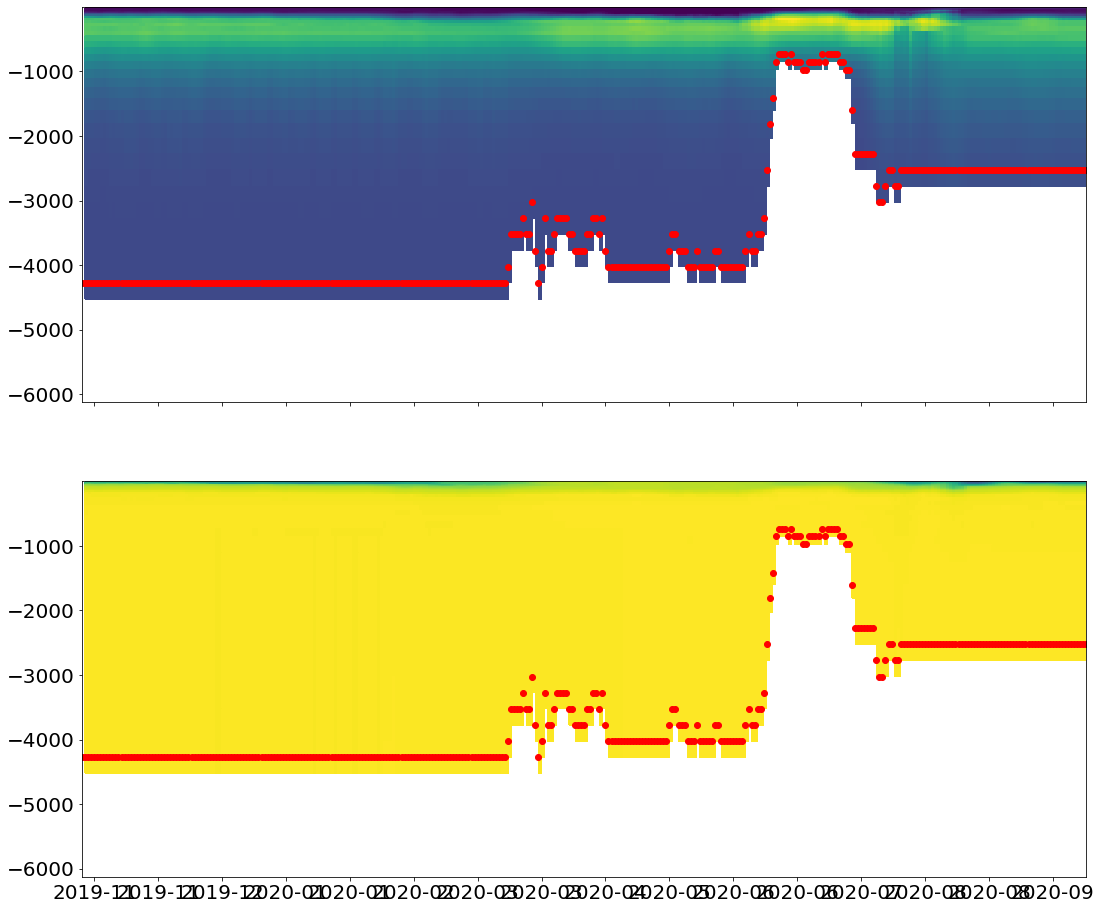

In [105]:
#
# 3rd processing step:
# perform a temporal moving average accounting for all profiles to smooth the temporal variablility

def moving_average_filter(array, window_width):
    # temporal moving average per depth level
    nx=len(array)
    radius=int(np.floor(window_width/2))
    average = np.zeros(len(array))
    for i in range(nx):
        ind1, ind2 = np.max([0,i-radius]), np.min([i+radius,nx-1])
        average[i]=np.nanmean(array[ind1:ind2+1])
    
    return average

class temporal_moving_average:
    def __init__(self, data, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, data.nlevels
        
        self.perform_moving_average(data,width)
        
    def perform_moving_average(self,data, width):
        # initialization
        temp, sal = np.zeros(data.salinity.shape), np.zeros(data.temperature.shape)
        print(temp.shape)
        nlvl = len(data.depth)
        
        # perform moving average on each level (salinity, temperature)
        for i in range(nlvl):
                # salinity
                S = data.salinity[:,i]
                index = np.where(np.isnan(S))[0]
                S = moving_average_filter(S, width)
                sal[:,i] = S 
                if len(index)>0:
                    sal[index,i] = np.nan
                    
                # temperature
                T = data.temperature[:,i]
                index = np.where(np.isnan(T))[0]
                T = moving_average_filter(T, width)
                temp[:,i] = T 
                if len(index)>0:
                    temp[index,i] = np.nan
        self.temperature, self.salinity = temp, sal
        
#
ITP_data_processed_3rd_step = temporal_moving_average(ITP_data_processed_2nd_step, window_width)
plot_variables_map(ITP_data_processed_3rd_step,mesh)

In [111]:
class Output(object):
    def __init__(self, filename, data):
        self.write_ocn_forcing(filename, data)
    
    def write_ocn_forcing(self,filename, data):
        #------------------------------------------------------------------------
        # write ITP salinity and temperature profile to netcdf
        #------------------------------------------------------------------------	
    
        # open file
        ncid = Dataset(filename, "w", format="NETCDF4")

        # define dimension
        nt, nlvl = len(data.dates), len(data.depth)
    
        ncid.createDimension('time', nt)
        ncid.createDimension('levels', nlvl)
        dimt, dimlvl, dim = ('time'), ('levels'), ('levels','time') 
        
        # create variable
        dat = ncid.createVariable('dates', "f8", dimt)
        D, nlev = ncid.createVariable('depth', "f8",dimlvl), ncid.createVariable('nlevels', "f8",dimt)
        sal, temp = ncid.createVariable('salinity', "f8",dim), ncid.createVariable('temperature', "f8",dim)

        
        # define units
        dat.units, dat.description = 'days', 'days since '+ str(datetime.fromordinal(int(data.dates[0])))
        D.units, nlev.units = 'm', ''
        sal.units, temp.units = 'PSU', 'degC' 
        sal.long_name, temp.long_name = 'practical salinity', 'potential temperature'
        #fill variables
        ncid['dates'][:] = data.dates
        ncid['depth'][:], ncid['nlevels'][:] = data.depth, data.nlevels 
        ncid['salinity'][:], ncid['temperature'][:] = data.salinity.T, data.temperature.T
   
        # close file
        ncid.close()
#
# write to data to netcdf
#
data = ITP_data_processed_3rd_step if flag_smooth_output else ITP_data_processed_2nd_step
Output(filename_output, data)